In [2]:
import sys
print(sys.executable)

/home/tomislav/mambaforge-pypy3/envs/houses_tf/bin/python


In [85]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_decision_forests as tfdf

import mlflow


In [88]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("houses")

2023/09/12 14:40:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/09/12 14:40:05 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/media/tomislav/023ABC973ABC8965/Projekti/MLOps-Testing/src/mlruns/1', creation_time=1694522412773, experiment_id='1', last_update_time=1694522412773, lifecycle_stage='active', name='houses', tags={}>

In [25]:
dataset_path = "../data/house-prices-advanced-regression-techniques/"
tr_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))

In [26]:
tr_df.loc[tr_df["MasVnrArea"].isnull() & tr_df["MasVnrType"].isnull(), "MasVnrArea"] = 0.0
tr_df.dropna(subset=["Electrical"], inplace=True)
tr_df.drop(tr_df[tr_df["BsmtFinType1"].notnull() & tr_df["BsmtFinType2"].isnull()].index[0], inplace=True)
tr_df.loc[tr_df["LotFrontage"].isnull(), "LotFrontage"] = tr_df["LotFrontage"].mean()
tr_df.drop(columns="Id", inplace=True)

test_ids = test_df.pop('Id')

print(tr_df.shape)
print(test_df.shape)


(1458, 80)
(1459, 79)


In [27]:
print(len(tr_df))
val_ratio = 0.2
interval = len(tr_df) * val_ratio
interval = np.floor(interval).astype(np.int16)
print(interval)
print(interval*5)

splits = []
pool = np.array(range(len(tr_df)))
for i in range(int(1/val_ratio)):
    split = np.random.choice(pool, size=interval, replace=False)
    split = split.tolist()
    splits.append(split)
    print(i)
    pool = pool[np.isin(pool, split, invert=True)]
for i in range(len(splits)):
    print(len(splits[i]))

1458
291
1455
0
1
2
3
4
291
291
291
291
291


In [28]:
import tensorflow.keras.backend as K

def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred))

In [79]:

best_loss = 9999

for i in range(len(splits)):
    val_pool = splits[i]
    train_pool = []
    for j in range(len(splits)):
        if i == j:
            continue
        train_pool.append(splits[j])
    train_pool = np.hstack(train_pool).tolist()
    train_data = tr_df.iloc(axis=0)[train_pool]
    val_data = tr_df.iloc(axis=0)[val_pool]
    #print(val_pool)
    #print("val " + str(len(val_data)))
    #print(train_pool.shape)
    #print(train_pool.shape[0] + len(val_data))
    #print("train " + str(len(train_pool)) + " " + str(len(train_pool[0])))

    label = "SalePrice"
    train_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=label, task = tfdf.keras.Task.REGRESSION)
    val_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        val_data, label=label, task = tfdf.keras.Task.REGRESSION)

    
    #model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",
    #                                    task=tfdf.keras.Task.REGRESSION)
    
    model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    model.compile(
        loss = [tf.keras.losses.MeanSquaredLogarithmicError()],
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    model.fit(x=train_data, verbose=0)

    #inspector = model.make_inspector()
    #inspector.evaluation()

    eval = model.evaluate(x=val_data, return_dict=True)
    #for name, value in eval.items():
    #    print(f"{name}: {value:.4f}")

    model_loss = eval["loss"]
    if model_loss < best_loss:
        best_loss = model_loss
        best_model = tf.keras.models.clone_model(model)


    

        
            


[INFO 23-09-12 11:06:06.9531 CEST kernel.cc:1243] Loading model from path /tmp/tmp32dhqnk_/model/ with prefix 86e3a33d2996408d
[INFO 23-09-12 11:06:07.2664 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110542 node(s), and 73 input feature(s).
[INFO 23-09-12 11:06:07.2664 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-12 11:06:07.2664 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 285ms/step - loss: 0.0236 - rmse: 35965.8398


[INFO 23-09-12 11:06:10.4976 CEST kernel.cc:1243] Loading model from path /tmp/tmpbkq9cvb6/model/ with prefix 600d8b2a951b4d73
[INFO 23-09-12 11:06:10.7769 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110500 node(s), and 73 input feature(s).
[INFO 23-09-12 11:06:10.7770 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 288ms/step - loss: 0.0155 - rmse: 30337.1816


[INFO 23-09-12 11:06:14.0603 CEST kernel.cc:1243] Loading model from path /tmp/tmp68u5ak7e/model/ with prefix 44f5f582bad54b5c
[INFO 23-09-12 11:06:14.3393 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110334 node(s), and 74 input feature(s).
[INFO 23-09-12 11:06:14.3393 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 268ms/step - loss: 0.0176 - rmse: 22216.2266


[INFO 23-09-12 11:06:17.6421 CEST kernel.cc:1243] Loading model from path /tmp/tmph06cecdt/model/ with prefix ddaa5f3829dd48e0
[INFO 23-09-12 11:06:17.9145 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110530 node(s), and 76 input feature(s).
[INFO 23-09-12 11:06:17.9146 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-12 11:06:17.9146 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 267ms/step - loss: 0.0198 - rmse: 26366.2070


[INFO 23-09-12 11:06:21.0048 CEST kernel.cc:1243] Loading model from path /tmp/tmp4y9695il/model/ with prefix 76f2042ffce94fb3
[INFO 23-09-12 11:06:21.2768 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110406 node(s), and 75 input feature(s).
[INFO 23-09-12 11:06:21.2769 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 278ms/step - loss: 0.0217 - rmse: 27893.2031


In [105]:
mlflow.tensorflow.autolog(disable=True)
with mlflow.start_run(run_name='rf_baseline'):
    params = {
        'bootstrap_training_dataset': True,
        'bootstrap_size_ratio': 1.0,
        'max_depth': 16,
        'max_num_nodes': None,
        'num_trees': 300,
    }

    mlflow.set_tag("model_name", "RF")
    

    i=1 
    val_pool = splits[i]
    train_pool = []
    for j in range(len(splits)):
        if i == j:
            continue
        train_pool.append(splits[j])
    train_pool = np.hstack(train_pool).tolist()
    train_data = tr_df.iloc(axis=0)[train_pool]
    val_data = tr_df.iloc(axis=0)[val_pool]

    label = "SalePrice"
    train_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=label, task = tfdf.keras.Task.REGRESSION)
    val_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        val_data, label=label, task = tfdf.keras.Task.REGRESSION)


    #model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",
    #                                    task=tfdf.keras.Task.REGRESSION)

    model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0,
                bootstrap_training_dataset=params['bootstrap_training_dataset'],
                bootstrap_size_ratio=params['bootstrap_size_ratio'],
                max_depth=params['max_depth'],
                max_num_nodes=params['max_num_nodes'],
                num_trees=params['num_trees'])

    model.compile(
        loss = [tf.keras.losses.MeanSquaredLogarithmicError()],
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    params = model.learner_params
    import pprint
    pprint.pprint(pprint.pformat(params, depth=1))
    #print(params)

    model.fit(x=train_data, verbose=0)


    eval = model.evaluate(x=val_data, return_dict=True)
    #for name, value in eval.items():
    #    print(f"{name}: {value:.4f}")


("DictWrapper({'adapt_bootstrap_size_ratio_for_maximum_training_duration': "
 "False, 'allow_na_conditions': False, 'bootstrap_size_ratio': 1.0, "
 "'bootstrap_training_dataset': True, 'categorical_algorithm': 'CART', "
 "'categorical_set_split_greedy_sampling': 0.1, "
 "'categorical_set_split_max_num_items': -1, "
 "'categorical_set_split_min_item_frequency': 1, 'compute_oob_performances': "
 "True, 'compute_oob_variable_importances': False, 'growing_strategy': "
 "'LOCAL', 'honest': False, 'honest_fixed_separation': False, "
 "'honest_ratio_leaf_examples': 0.5, 'in_split_min_examples_check': True, "
 "'keep_non_leaf_label_distribution': True, 'max_depth': 16, 'max_num_nodes': "
 "None, 'maximum_model_size_in_memory_in_bytes': -1.0, "
 "'maximum_training_duration_seconds': -1.0, 'min_examples': 5, "
 "'missing_value_policy': 'GLOBAL_IMPUTATION', 'num_candidate_attributes': 0, "
 "'num_candidate_attributes_ratio': -1.0, "
 "'num_oob_variable_importances_permutations': 1, 'num_trees': 3

[INFO 23-09-12 15:16:10.1174 CEST kernel.cc:1243] Loading model from path /tmp/tmp_fchz60l/model/ with prefix c8c4f8ffd251404c
[INFO 23-09-12 15:16:10.4098 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110500 node(s), and 73 input feature(s).
[INFO 23-09-12 15:16:10.4099 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 301ms/step - loss: 0.0155 - rmse: 30337.1816


In [100]:
params = {
    'bootstrap_training_dataset': True,
    'bootstrap_size_ratio': 1.0,
    'max_depth': 16,
    'max_num_nodes': None,
    'num_trees': 300,
}

In [82]:
#best_model = tf.keras.models.load_model("../saved_models/houses_best", 
#                custom_objects={'loss': root_mean_squared_log_error}, compile=True)
#loaded_model.compile(
#        loss=[root_mean_squared_log_error],
#        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

model.summary()
eval = model.evaluate(x=val_data, return_dict=True)

for name, value in eval.items():
        print(f"{name}: {value:.4f}")

test_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_df, task = tfdf.keras.Task.REGRESSION)

preds = model.predict(x=test_data)
output = pd.DataFrame({'Id':test_ids, 
                       'SalePrice':preds.squeeze()})

output.head()

submission_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/sample_submission.csv")
submission_df["SalePrice"] = model.predict(test_data)
submission_df.to_csv("../kaggle/working/submission.csv", index=False)
submission_df.head()

Model: "random_forest_model_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (79):
	1stFlrSF
	2ndFlrSF
	3SsnPorch
	Alley
	BedroomAbvGr
	BldgType
	BsmtCond
	BsmtExposure
	BsmtFinSF1
	BsmtFinSF2
	BsmtFinType1
	BsmtFinType2
	BsmtFullBath
	BsmtHalfBath
	BsmtQual
	BsmtUnfSF
	CentralAir
	Condition1
	Condition2
	Electrical
	EnclosedPorch
	ExterCond
	ExterQual
	Exterior1st
	Exterior2nd
	Fence
	FireplaceQu
	Fireplaces
	Foundation
	FullBath
	Functional
	GarageArea
	GarageCars
	GarageCond
	GarageFinish
	GarageQual
	GarageType
	GarageYrBlt
	GrLivArea
	HalfBath
	Heating
	HeatingQC
	HouseStyle
	KitchenAbvGr
	KitchenQual
	LandContour
	LandSlope
	LotArea
	LotConfig
	LotFrontage
	LotSha

,Id,SalePrice
0,1461,126641.460938
1,1462,154353.984375
2,1463,176422.375000
3,1464,182134.046875
4,1465,196776.234375


In [84]:
submission_df.head()
print(submission_df.shape)

(1459, 2)


In [7]:
model.summary()

Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (79):
	1stFlrSF
	2ndFlrSF
	3SsnPorch
	Alley
	BedroomAbvGr
	BldgType
	BsmtCond
	BsmtExposure
	BsmtFinSF1
	BsmtFinSF2
	BsmtFinType1
	BsmtFinType2
	BsmtFullBath
	BsmtHalfBath
	BsmtQual
	BsmtUnfSF
	CentralAir
	Condition1
	Condition2
	Electrical
	EnclosedPorch
	ExterCond
	ExterQual
	Exterior1st
	Exterior2nd
	Fence
	FireplaceQu
	Fireplaces
	Foundation
	FullBath
	Functional
	GarageArea
	GarageCars
	GarageCond
	GarageFinish
	GarageQual
	GarageType
	GarageYrBlt
	GrLivArea
	HalfBath
	Heating
	HeatingQC
	HouseStyle
	KitchenAbvGr
	KitchenQual
	LandContour
	LandSlope
	LotArea
	LotConfig
	LotFrontage
	LotShape

In [55]:
model_params = model.learner_params
print(model_params)
param1 = model_params["honest_ratio_leaf_examples"]

AttributeError: 'RandomForestModel' object has no attribute 'learner_params'

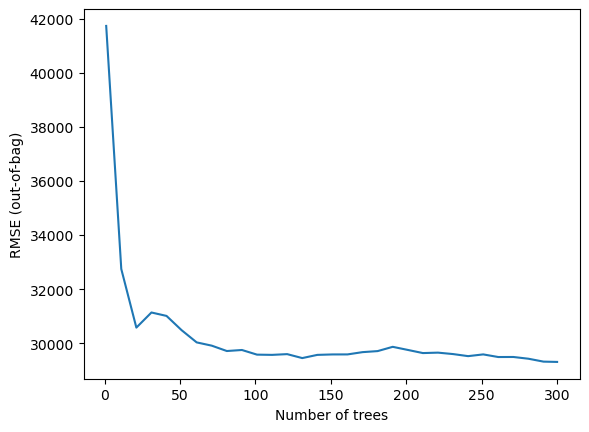

Evaluation(num_examples=1164, accuracy=None, loss=None, rmse=29307.852699248662, ndcg=None, aucs=None, auuc=None, qini=None)

In [8]:
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

inspector = model.make_inspector()
inspector.evaluation()

In [89]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [125]:
nullseries = tr_df.isnull().sum()
print(nullseries[nullseries > 0])

Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
